## Importing libraries

In [1]:
from pycaret.nlp import *
import pandas as pd
import scipy.sparse as sp
import numpy as np
import nltk
from nltk.corpus import stopwords
stopword_es = nltk.corpus.stopwords.words('spanish')

import warnings
warnings.filterwarnings("ignore")

## Read corpus and stopwords

In [2]:
col_list = ["Document", "Class"]
corpus = pd.read_csv('Data/survey_corpus.csv', usecols=col_list)

In [3]:
corpus.head()

,Document,Class
0,igual proposito inspirar mujeres podemos hacer...,inspirado_por
1,necesariamente toda promocionan gran campaa en...,inspirado_por
2,diria si decidi ah inspira sino ver cifras cre...,inspirado_por
3,hizo reflexionar casi siempre veo contenido cu...,inspirado_por
4,entonces pienso inspiracional persona comunes ...,inspirado_por


In [4]:
# We create a framework with personalized stop words
stop_words = pd.read_csv("Data/stop_words_es.txt", sep=",", decimal=".", engine="python", encoding = 'utf8')

In [5]:
sw_list = stop_words["listasw"].values.tolist()

In [6]:
# Using customize stopwords before topic modeling
nlp = setup(data = corpus, target = "Document", custom_stopwords = sw_list, session_id = 12)

Description,Value
session_id,12
Documents,181
Vocab Size,507
Custom Stopwords,True


## Computing the best number of topics

In [7]:
from scipy.stats import entropy
entros = []
lista_topicos = []
for i in range(2,20):
    lda_bucle = create_model('lda', num_topics=i)
    lda_data_bucle = assign_model(lda_bucle)
    topics_por_bucle = lda_data_bucle[lda_data_bucle["Class"] == "inspirado_por"]
    topics_para_bucle = lda_data_bucle[lda_data_bucle["Class"] == "inspirado_para"]
    aux = []
    if (topics_por_bucle.Dominant_Topic.mode()[0] != topics_para_bucle.Dominant_Topic.mode())[0]:
        aux.append(i)
        aux.append(topics_por_bucle.Dominant_Topic.mode()[0])
        aux.append(topics_para_bucle.Dominant_Topic.mode()[0])
        pd_series = pd.Series(lda_data_bucle["Dominant_Topic"])
        pd_series_por = pd.Series(topics_por_bucle["Dominant_Topic"])
        pd_series_para = pd.Series(topics_para_bucle["Dominant_Topic"])
        entropyx = entropy(pd_series.value_counts())
        aux.append(entropy(pd_series_por.value_counts())/entropyx)
        aux.append(entropy(pd_series_para.value_counts())/entropyx)
        lista_topicos.append(aux)

In [9]:
lista_topicos

[[2, 'Topic 1', 'Topic 0', 0.9950959043738096, 1.0016655367875502],
 [6, 'Topic 4', 'Topic 3', 0.9563692542432761, 0.9912062721709524],
 [7, 'Topic 4', 'Topic 3', 0.9820962248288816, 0.9729521505301039],
 [8, 'Topic 4', 'Topic 0', 0.9647359103319549, 0.9960039663413762],
 [10, 'Topic 8', 'Topic 0', 0.9882323459443828, 0.9464483475388226],
 [11, 'Topic 8', 'Topic 10', 1.0046860826817847, 0.9669072535653594],
 [13, 'Topic 8', 'Topic 0', 0.9897361782720662, 0.9806442476961654],
 [15, 'Topic 10', 'Topic 8', 0.9966244433030998, 0.9584102651026151],
 [18, 'Topic 8', 'Topic 2', 1.0293343911528687, 0.8652411699581734]]

## LDA training for the best number of topics

In [10]:
# Set the number of topics (it would be used in other tasks)
n_topics = 3
# Creating the topic modeling task
lda = create_model('lda', num_topics = n_topics)

In [11]:
lda_data = assign_model(lda)
lda_data.head()

,Document,Class,Topic_0,Topic_1,Topic_2,Dominant_Topic,Perc_Dominant_Topic
0,igual proposito ropa comoda ropa bonita declar...,inspirado_por,0.006446,0.006655,0.986899,Topic 2,0.99
1,necesariamente gran campaa envian ciertas pren...,inspirado_por,0.005091,0.005256,0.989653,Topic 2,0.99
2,decidi inspira sino ver cifra creo algun rabia...,inspirado_por,0.988545,0.004343,0.007112,Topic 0,0.99
3,tema presente mujer,inspirado_por,0.022215,0.022933,0.954851,Topic 2,0.95
4,pienso inspiracional persona comune utilizan p...,inspirado_por,0.007074,0.980977,0.011950,Topic 1,0.98


In [12]:
# Resume the topic modeling task
lda_data.groupby(["Dominant_Topic","Class"])["Document"].count()

Dominant_Topic  Class         
Topic 0         inspirado_para    22
                inspirado_por     21
Topic 1         inspirado_para    17
                inspirado_por     35
Topic 2         inspirado_para    38
                inspirado_por     48
Name: Document, dtype: int64

In [13]:
Fig1 = plot_model(lda, plot = 'topic_distribution')

In [14]:
import plotly.express as px
fig2 = px.bar(lda_data, x=lda_data["Dominant_Topic"], y=lda_data["Perc_Dominant_Topic"], color=lda_data["Class"])
fig2.write_html("Figures/acumm_distri.html")
fig2.show()

In [15]:
Fig3 = plot_model(lda, plot = 'topic_model')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.043815  0.126922       1        1  43.427164
0      0.120457 -0.024762       2        1  31.388058
1     -0.076642 -0.102160       3        1  25.184778, topic_info=              Term       Freq      Total Category  logprob  loglift
155           nike   9.000000   9.000000  Default  30.0000  30.0000
48         deporte  48.000000  48.000000  Default  29.0000  29.0000
44         persona  17.000000  17.000000  Default  28.0000  28.0000
35             ver  25.000000  25.000000  Default  27.0000  27.0000
8             ropa  22.000000  22.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
25            creo   3.148999  13.316834   Topic3  -4.6624  -0.0630
43      obviamente   2.145439   4.577991   Topic3  -5.0461   0.6210
88   alguna_manera   2.061016   4.578698   Topic3  -5.0863   0.5807
48         deporte   2.932225  48.929463   Topic3  -4.7337  -1.4357
408           hora   2.032377   6.180393   Topic3  -5.1003   0.2668

[177 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
80        1  0.780833   accion
80        3  0.260278   accion
248       1  0.904912  accione
294       3  0.846773      ahi
22        1  0.409652    algun
...     ...       ...      ...
199       1  0.632665      voy
199       2  0.253066      voy
199       3  0.126533      voy
318       3  0.940415   vuelve
165       1  0.693956  youtube

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## Organizing data for visualization

In [16]:
# Separe documents by topic and by class
topics_por = lda_data[lda_data["Class"] == "inspirado_por"]
topics_para = lda_data[lda_data["Class"] == "inspirado_para"]

In [20]:
# Vectorization of textual data
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer()
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [21]:
n_words = 20 # Number of words by topic
aux_all_common_words = []
aux_topic_list = []
df_word_per_topic = pd.DataFrame()
for i in range(n_topics):
    topic_num = "Topic " + str(i)
    filtered_df = lda_data.loc[lda_data["Dominant_Topic"] == topic_num]
    common_words = get_top_n_words(filtered_df["Document"], n=n_words)
    for word in common_words:
        aux_topic_list.append(i)
        aux_all_common_words.append(word)
df_word_per_topic = pd.DataFrame(aux_all_common_words, columns=["Text", "count"])
df_word_per_topic['Topic'] = aux_topic_list

In [22]:
pd.set_option('display.max_rows', None)

In [23]:
# Delete some words providing by experts
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "creo"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "puede"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "pueda"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "siempre"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "ultimo"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "algun"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "comune"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "solo"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "final"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "tema"].index, inplace=True)
df_word_per_topic.drop(df_word_per_topic[df_word_per_topic["Text"] == "send"].index, inplace=True)
df_word_per_topic.reset_index(drop=True, inplace=True)

In [24]:
# List of words per topics in spanish selected by experts
List_experts_0 = ['ver', 'persona', 'ropa', 'deporte', 'nike', 'hacer', 'correr', 'mensaje', 'chevere','sentir']
List_experts_1 = ['persona', 'inspira', 'deportista', 'inspiracion', 'hazlo', 'grande', 'deporte', 
                  'resultado', 'marca', 'inspiracional']
List_experts_2 = ['deporte', 'hacer', 'ver', 'ropa', 'video', 'marca', 'vida', 'siento', 'visto', 'voy']

In [25]:
# List of words per topics in english selected by experts
List_experts_0 = ['see','person','clothes','sport','nike','do','run','message','cool','feel']
List_experts_1 = ['person','inspire','athlete','inspiration','do it','big','sport','result','brand','inspirational']
List_experts_2 = ['sport','do','see','clothes','video','brand','life', 'athlete','seen','I go']

In [26]:
words = ['see','person','clothes','sport','nike','do','run','message','cool','feel','mujer','diferente','comercial',
         'veia','hora','person','inspire','athlete','inspiration','do it','big','sport','cuanto',
         'mejor','result','cualqui','brand','inspirational','utilizan','obviamente','sport','do','see','clothes',
         'video','brand','life', 'athlete','seen','I go','comercial','athlete','inspiration','haciendo','igual']
len(words)

45

In [27]:
df_word_per_topic.rename(columns = {'Text':'Text_sp'}, inplace = True)

In [28]:
df_word_per_topic.head()

,Text_sp,count,Topic
0,ver,10,0
1,persona,9,0
2,ropa,9,0
3,deporte,9,0
4,nike,8,0


In [29]:
df_word_per_topic['Text'] = words

In [30]:
df_word_per_topic

,Text_sp,count,Topic,Text
0,ver,10,0,see
1,persona,9,0,person
2,ropa,9,0,clothes
3,deporte,9,0,sport
4,nike,8,0,nike
5,hacer,7,0,do
6,correr,7,0,run
7,mensaje,7,0,message
8,chevere,6,0,cool
9,sentir,4,0,feel


In [31]:
df_word_per_topic = df_word_per_topic[df_word_per_topic['Text'].isin(List_experts_0+List_experts_1+List_experts_2)]
df_word_per_topic.drop(df_word_per_topic.tail(1).index,inplace=True)

In [32]:
df_word_per_topic

,Text_sp,count,Topic,Text
0,ver,10,0,see
1,persona,9,0,person
2,ropa,9,0,clothes
3,deporte,9,0,sport
4,nike,8,0,nike
5,hacer,7,0,do
6,correr,7,0,run
7,mensaje,7,0,message
8,chevere,6,0,cool
9,sentir,4,0,feel


In [33]:
df_word_per_topic = df_word_per_topic.reset_index()

In [34]:
my_key_list = df_word_per_topic['Text'].to_list()
plot_dictionary = dict.fromkeys(my_key_list)
for key_val in range(len(my_key_list)):
    my_key = df_word_per_topic['Text'][key_val]
    if my_key in plot_dictionary:
        if not isinstance(plot_dictionary[my_key], list):
            # converting key to list type
            plot_dictionary[my_key] = [plot_dictionary[my_key]]
        # Append the key's value in list
        plot_dictionary[my_key].append([df_word_per_topic['count'][key_val],df_word_per_topic['Topic'][key_val]])

In [35]:
plot_dictionary

{'see': [None, [10, 0], [20, 2]],
 'person': [None, [9, 0], [15, 1]],
 'clothes': [None, [9, 0], [19, 2]],
 'sport': [None, [9, 0], [5, 1], [45, 2]],
 'nike': [None, [8, 0]],
 'do': [None, [7, 0], [21, 2]],
 'run': [None, [7, 0]],
 'message': [None, [7, 0]],
 'cool': [None, [6, 0]],
 'feel': [None, [4, 0]],
 'inspire': [None, [7, 1]],
 'athlete': [None, [6, 1], [8, 2], [5, 2]],
 'inspiration': [None, [6, 1]],
 'do it': [None, [6, 1]],
 'big': [None, [5, 1]],
 'result': [None, [4, 1]],
 'brand': [None, [4, 1], [10, 2]],
 'inspirational': [None, [3, 1]],
 'video': [None, [12, 2]],
 'life': [None, [9, 2]],
 'seen': [None, [7, 2]],
 'I go': [None, [6, 2]]}

## Visualization of words -> topics

In [37]:
source = []
target = []
values = []
words = []
color_link = []
c = 0
domin_por = [int(s) for s in topics_por.Dominant_Topic.mode()[0].split() if s.isdigit()][0]
domin_para = [int(s) for s in topics_para.Dominant_Topic.mode()[0].split() if s.isdigit()][0]
for key, list_value in plot_dictionary.items():
    words.append(key)
    for j in range(1,len(list_value)):
        source.append(c+(n_topics))
        target.append(list_value[j][1])
        values.append(list_value[j][0])
        if list_value[j][1] == 1 : 
            color_link.append('#5086c6')
        elif list_value[j][1] == 0 : 
            color_link.append('#ed553b')
        else: 
            color_link.append('#dedede')
    c += 1

In [38]:
topicos = []
labels = []
for j in range(0,n_topics):
    aux = "Topic " + str(j)
    topicos.append(aux)
labels.extend(topicos)
labels.extend(words)

In [39]:
#https://plotly.com/python/sankey-diagram/
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_format = "png"
Fig4 = go.Figure(go.Sankey(
    arrangement = "snap",
    node = dict(
        label = labels,
        #"x": [0.8, 0.8, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        #"y": [0.8, 0.8, 0.8, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        #pad = 50,
        color = "#0a553b",
        #thickness = 5 #Pixels
        #color = color_link,
        ),  
    link = dict(
        source = source,
        target = target,
        value = values,
        color = color_link)))

Fig4.update_layout(
    hovermode = 'x',
    font=dict(size = 20, color = 'black'),
    #plot_bgcolor='black',
    #paper_bgcolor='black'
)
pio.write_image(Fig4, 'Figures/sankey.png', width=1600, height=850, scale=1.5)
#Fig4.write_html("Figures/sankey.html")
Fig4.show()

## Distance between tweets and topics

In [40]:
tweets = pd.read_csv('Data/tweets_corpus.csv')

In [41]:
tweets.head()

,tweet
0,peligro eche nike dimite traidor
1,cambiaron nike publicidad club
2,hace nyc impacto menos downtown midtown hecha ...
3,alguien puede ayudarme puedo comprar tenis nik...
4,entonces llega camiseta nike


In [42]:
import spacy
nlp = spacy.load('es_core_news_sm')

In [43]:
v_topic0 = nlp(' '.join(df_word_per_topic.loc[df_word_per_topic['Topic'] == 0]['Text'].tolist()))
v_topic1 = nlp(' '.join(df_word_per_topic.loc[df_word_per_topic['Topic'] == 1]['Text'].tolist()))
simi_top1_tweet = []
simi_top0_tweet = []
tweet_vec = []
i = 1
for i in range(len(tweets)):
    if (len(tweets['tweet'][i].split()) >= 3):
        tweet = nlp(tweets['tweet'][i])
        tweet_vec.append(tweets['tweet'][i])
        tweet_topic0 = v_topic0.similarity(tweet)
        simi_top0_tweet.append(tweet_topic0)
        tweet_topic1 = v_topic1.similarity(tweet)
        simi_top1_tweet.append(tweet_topic1)

In [44]:
data_tuples = list(zip(tweet_vec,simi_top0_tweet,simi_top1_tweet))

In [45]:
df_simi = pd.DataFrame(data_tuples, columns=['Tweet','Topic0','Topic1'])

In [46]:
df_simi.tail()

,Tweet,Topic0,Topic1
6397,descuento nike chance encuentras,0.536238,0.588120
6398,nuevo capricho quiero unas nike dunk cuales,0.459810,0.383272
6399,titular encima tener tremendo olympikus frente...,0.618046,0.616539
6400,si banda fideos,0.310588,0.311635
6401,instalacion easy fifa mod manager seleccionar ...,0.764621,0.829230


In [47]:
df_simi.loc[df_simi['Topic0'] >= 0.8]

,Tweet,Topic0,Topic1
29,mientras dueos nike adidas puma etc sientan to...,0.809791,0.758966
54,barcelona inter liverpool psg chelsea atletico...,0.819212,0.803134
133,nike mundial agradece comentario esperan usa d...,0.803215,0.786528
137,mencio clubes nike dejo nike queria si nike de...,0.800674,0.833653
206,ahi dao colega tiempo recreo coser pelota pa n...,0.829223,0.766182
643,barcelona fichas ferran traen copia china cami...,0.801605,0.816355
744,volviendo empire outlet aunque compre vale pen...,0.814642,0.830451
829,jezi juu ferran torres haina beji barcelona na...,0.800464,0.793754
1053,fair play cambium cada ao igual limite salaria...,0.816237,0.813051
1208,dale cuida pise nike jaja cuello bajo cero ice...,0.817362,0.890089


In [48]:
res_topic1 = df_simi.loc[df_simi['Topic1'] - df_simi['Topic0'] >= 0.1].head(10).sort_values(by=['Topic0'], ascending=False)
res_topic1

,Tweet,Topic0,Topic1
131,aqui nuevos bb air force next nature valio pen...,0.736749,0.844933
1094,irma for intimate time intimate time handsome ...,0.708161,0.821732
289,ferran torres jugando partido escudo sponsor n...,0.698320,0.801802
956,conjunto espaol empato gol frente napoles camp...,0.698027,0.801175
975,camiseta edicion especial aik royal edition,0.645969,0.747013
353,perdonen relatores di cuenta,0.565834,0.666292
81,puma tito torres visite ahora viste umbro puma...,0.560436,0.662558
434,escudo logo nike comprado camiseta mantero rambla,0.548834,0.658225
312,arquero sobrepeso medio rarito,0.311998,0.423662
938,favor jaja asi,0.293534,0.403656


In [49]:
res_topic0 = df_simi.loc[df_simi['Topic0'] - df_simi['Topic1'] >= 0.1].head(10).sort_values(by=['Topic1'], ascending=False)
res_topic0

,Tweet,Topic0,Topic1
518,razon deuda eterna,0.694953,0.579175
291,nike q drippin,0.571117,0.469891
463,ma menos falta escudo marca nike,0.561967,0.456540
341,tan mal barcelona pillando camisetas aliexpress,0.535003,0.427722
128,ser justos usa nike,0.508536,0.399725
98,flansito obvio si saldria nike obvio puma dupl...,0.521634,0.397048
386,tan malo nike bara quieren cerca,0.454944,0.343283
388,tiempo austeridad si cumplimos,0.405120,0.245572
458,escudo logo nike deben ser invisibles,0.248461,0.129491
571,nike siendo nike,0.218596,0.050029


## Embedding (skip-gram) inspired for

In [50]:
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize

In [51]:
ipor = corpus[corpus["Class"] == 'inspirado_por']

In [52]:
lista_words_ipor = ' '.join(ipor.Document.to_list())

In [53]:
len(lista_words_ipor)

20123

In [54]:
data_ipor = []
for i in sent_tokenize(lista_words_ipor):
    temp = []
     
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
 
    data_ipor.append(temp)

In [55]:
model_skip_ipor = gensim.models.Word2Vec(data_ipor, min_count = 1, vector_size = 20000, window = 15, sg = 1)

/opt/anaconda3/envs/dm/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any 

/opt/anaconda3/envs/dm/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any 

/opt/anaconda3/envs/dm/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any 

/opt/anaconda3/envs/dm/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any 

In [56]:
vector_skip_ipor = model_skip_ipor.wv['deporte'] 
sims_skip_ipor = model_skip_ipor.wv.most_similar('deporte', topn=40)
sims_skip_ipor

[('entonces', 0.9999924302101135),
 ('si', 0.9999920725822449),
 ('tiempo', 0.9999918341636658),
 ('puedes', 0.999991774559021),
 ('ser', 0.999991774559021),
 ('nike', 0.9999916553497314),
 ('ver', 0.9999916553497314),
 ('tema', 0.9999915957450867),
 ('siempre', 0.9999915957450867),
 ('ahi', 0.9999915361404419),
 ('bien', 0.9999914765357971),
 ('va', 0.9999914765357971),
 ('comerciales', 0.9999914765357971),
 ('tipo', 0.9999914765357971),
 ('bastante', 0.9999914169311523),
 ('hacer', 0.9999914169311523),
 ('bueno', 0.9999914169311523),
 ('cierto', 0.9999913573265076),
 ('ma', 0.9999912977218628),
 ('vi', 0.9999912977218628),
 ('veces', 0.9999911785125732),
 ('puedo', 0.9999911785125732),
 ('mejor', 0.9999911785125732),
 ('motivacion', 0.9999911189079285),
 ('luego', 0.9999911189079285),
 ('zapatillas', 0.9999910593032837),
 ('diferentes', 0.9999910593032837),
 ('haciendo', 0.9999910593032837),
 ('dice', 0.9999910593032837),
 ('sino', 0.9999910593032837),
 ('voy', 0.9999909996986389),
 

## Embeddings (skip-gram) for inspired by

In [57]:
ipara = corpus[corpus["Class"] == 'inspirado_para']

In [58]:
lista_words_ipara = ' '.join(ipara.Document.to_list())

In [59]:
data_ipara = []
for i in sent_tokenize(lista_words_ipara):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data_ipara.append(temp)

In [60]:
model_skip_ipara = gensim.models.Word2Vec(data_ipara, min_count = 1, vector_size = 20000, window = 15, sg = 1)

In [61]:
vector_skip_ipara = model_skip_ipara.wv['deporte'] 
sims_skip_ipara = model_skip_ipara.wv.most_similar('deporte', topn=30)
sims_skip_ipara

[('entonces', 0.9999926090240479),
 ('si', 0.9999924898147583),
 ('ropa', 0.9999924302101135),
 ('marca', 0.9999916553497314),
 ('veces', 0.9999914169311523),
 ('asi', 0.9999913573265076),
 ('persona', 0.9999911785125732),
 ('video', 0.9999911189079285),
 ('ver', 0.9999910593032837),
 ('bueno', 0.9999908804893494),
 ('vi', 0.9999908208847046),
 ('zapatillas', 0.999990701675415),
 ('ganas', 0.9999905228614807),
 ('inspira', 0.9999903440475464),
 ('hacer', 0.9999902844429016),
 ('veo', 0.9999902248382568),
 ('nike', 0.9999901652336121),
 ('seguir', 0.9999901056289673),
 ('manera', 0.999989926815033),
 ('creo', 0.999989926815033),
 ('motivacion', 0.999989926815033),
 ('comprar', 0.9999898672103882),
 ('quiero', 0.9999898076057434),
 ('motiva', 0.9999897480010986),
 ('veia', 0.9999896883964539),
 ('ma', 0.9999895691871643),
 ('pucha', 0.9999894499778748),
 ('presente', 0.9999894499778748),
 ('f', 0.99998939037323),
 ('puedo', 0.9999893307685852)]

## Wordclouds

In [62]:
from wordcloud import WordCloud, STOPWORDS
import wordcloud as wc
import matplotlib.pyplot as plt
from itertools import combinations, chain
from PIL import Image
import numpy as np

In [63]:
#txt_persona_por = "visto deportistas comercial trayectoria ejemplo nike va puedes deporte ser zapatillas haciendo inspiracion solo pienso"
txt_person_for = "seen athletes advertisement trajectory example nike he/she_goes you_can sport be sneakers doing inspiration just I_think"
test_keys= txt_person_for.split(' ')
test_values= [2] * len(test_keys)
dict_person_for = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

In [64]:
#txt_persona_para = "deporte ropa marca zapatillas nike seguir ver hacer ganas inspira discapacidad creo comprar manera quiero"
txt_person_by = "sport clothes brand sneakers nike follow see do desire ispire disability I_believe buy manner I_want"
test_keys= txt_person_by.split(' ')
test_values= [2] * len(test_keys)
dict_person_by = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

In [65]:
#txt_deporte_por = "puedes ser nike ver va comerciales hacer mejor motivacion zapatillas haciendo voy ejemplo persona correr"
txt_sport_for = "you_can be nike see he/she_goes advertisements do better motivation sneakers doing I_go example person run"
test_keys= txt_sport_for.split(' ')
test_values= [2] * len(test_keys)
dict_sport_for = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

In [66]:
#txt_deporte_para = "ropa marca persona ver zapatillas ganas inspira hacer nike seguir motivacion comprar quiero motiva veia"
txt_sport_by = "clothes brand person see sneakers desire inspire do nike follow motivation buy I_want motivates I_saw"
test_keys= txt_sport_by.split(' ')
test_values= [2] * len(test_keys)
dict_sport_by = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

In [67]:
import string
# 2+ consecutive letters (also include apostrophes), e.x It's
normal_word = r"(?:\w[\w/]+)"
# 2+ consecutive punctuations, e.x. :)
ascii_art = r"(?:[{punctuation}][{punctuation}]+)".format(punctuation=string.punctuation)
regexp = r"{normal_word}|{ascii_art}".format(normal_word=normal_word, ascii_art=ascii_art)

In [68]:
wordcloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",
        #colormap="Blues",
        color_func=wc.get_single_color_func('Blue'),
        collocations=False,
        regexp=regexp,
        ).generate_from_frequencies(dict_sport_for)

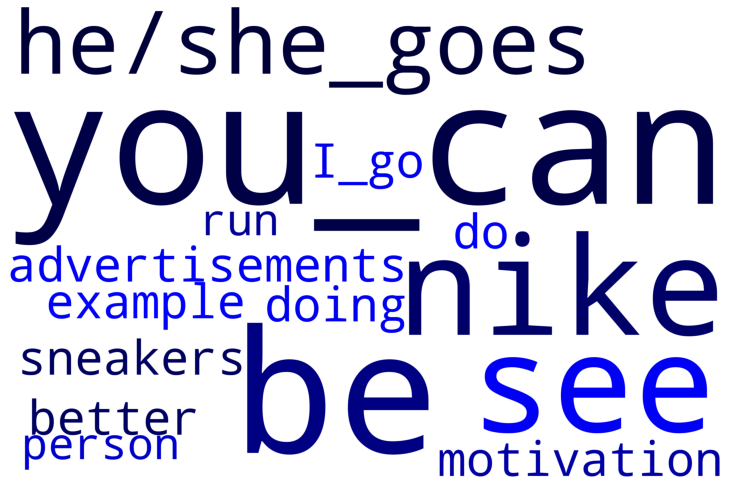

/opt/anaconda3/envs/dm/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any 

/opt/anaconda3/envs/dm/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any 

/opt/anaconda3/envs/dm/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/dm/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any 

In [63]:
plt.figure(figsize = (10, 10), facecolor = None, )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
#plt.savefig('Figures/dict_sport_for.png')
plt.show()